In [1]:
from numpy.random import seed
seed(1)

%load_ext autoreload
%autoreload 2

from PatientSet import *
from Constants import Constants
import Metrics
from analysis import *
from copy import copy
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from Classifiers import *
from Clustering import *

Using TensorFlow backend.


In [2]:
import seaborn as sns
font_scale = 1.5
line_width = 9
palette = 'colorblind'
fig_height = 15
aspect = 1.4

sns.set_context("paper", 
               font_scale = font_scale,
                rc={'figure.figsize':(17,17),
                    'lines.linewidth':line_width
                   }
               )

In [3]:
db = load_patientset()
default_clusterer = lambda : FClusterer(5, dist_func = l2)

In [4]:
patient_info = pd.read_csv('data/patient_info.csv', index_col = 0).sort_index()
patient_info = patient_info.loc[db.ids,:]
patient_info.head()

,ROI,Age at Diagnosis (Calculated),Pathological Grade,Gender,Race,Therapeutic combination,Tm Laterality (R/L),Tumor subsite (BOT/Tonsil/Soft Palate/Pharyngeal wall/GPS/NOS),Affected Lymph node,Affected Lymph node cleaned,...,FDM (months),Total dose,Total fractions,Treatment duration (Days),Dose/fraction (Gy),Feeding tube 6m,Aspiration rate Pre-therapy,Aspiration rate Post-therapy,Aspiration rate(Y/N),Aspiration type
Dummy ID,,,,,,,,,,,,,,,,,,,,,
3,GTVp1,60.222222,II,Female,White/Caucasion,CC,L,Tonsil,"L2, L3","L2, L3",...,88.833333,70.00,33,54.0,2.121212,N,N,N,N,NaN
4,GTVp1,66.344444,III,Male,White/Caucasion,CC,R,BOT,R2,R2,...,72.766667,66.00,30,39.0,2.200000,N,N,N,N,NaN
10,NaN,56.336111,II,Male,White/Caucasion,CC,R,NOS,R3,R3,...,143.033333,69.96,33,45.0,2.120000,N,N,N,N,NaN
11,GTVp1,49.566667,III,Male,White/Caucasion,CC,L,BOT,L2,L2,...,143.200000,70.00,33,44.0,2.121212,N,N,N,N,NaN
27,GTVp1,55.200000,III,Male,White/Caucasion,IC+Radiation alone,R,Tonsil,"R2, R3","R2, R3",...,124.866667,66.00,30,38.0,2.200000,N,N,N,N,NaN


In [5]:
#cohort statistics
descriptive_data = pd.DataFrame(db.ids, columns =['Id'])
summary_columns = ['ages','prescribed_doses']
descriptive_columns = ['pathological_grades',
           'genders', 'hpv', 
           'ajcc8','t_categories',
           'n_categories', 'Race',
           'smoking','subsites',
           'Therapeutic combination']
def get_df(columns):
    data = pd.DataFrame(db.ids, columns =['Id']).set_index('Id')
    for col in columns:
        try:
            data[col] = getattr(db, col)
        except Exception as e:
            print(e)
            try: 
                data[col] = patient_info[col]
            except Exception as e2:
                print(e2)
    return(data)
descriptive_data = get_df(descriptive_columns)
summary_data = get_df(summary_columns)

'PatientSet' object has no attribute 'Race'
'PatientSet' object has no attribute 'Therapeutic combination'


In [6]:
#continuous variables summary
summary_data.describe()

,ages,prescribed_doses
count,200.00000,200.000000
mean,59.40500,68.511500
std,8.74318,2.097473
min,37.00000,60.000000
25%,53.00000,66.000000
50%,58.50000,70.000000
75%,66.00000,70.000000
max,82.00000,72.000000


In [7]:
#summary of categorical features in the data (count + percent)
#may want to add a p value or something?
indexes = np.array(['count', 'percent'])
pcount = descriptive_data.shape[0]
for col in descriptive_data.columns:
    unique_values = np.unique(descriptive_data[col])
    n_unique = len(unique_values)
    sub_table = pd.DataFrame(index = indexes)
    for val in unique_values:
        count = len(np.argwhere(descriptive_data[col] == val).ravel())
        percent = 100*count/pcount
        sub_table[val] = np.array([count, percent])
    print(col)
    print(sub_table.head())
    print()

pathological_grades
           I    II    III   IV   nan
count    1.0  53.0  105.0  2.0  39.0
percent  0.5  26.5   52.5  1.0  19.5

genders
         Female   Male
count      28.0  172.0
percent    14.0   86.0

hpv
         -1.0   0.0    1.0
count    20.0  50.0  130.0
percent  10.0  25.0   65.0

ajcc8
          0.0   1.0    2.0  3.0   4.0
count    51.0  20.0  103.0  7.0  19.0
percent  25.5  10.0   51.5  3.5   9.5

t_categories
           T1    T2    T3    T4  Tis   Tx
count    52.0  85.0  43.0  18.0  1.0  1.0
percent  26.0  42.5  21.5   9.0  0.5  0.5

n_categories
           0     1      2    3
count    7.0  25.0  163.0  5.0
percent  3.5  12.5   81.5  2.5

Race
         African American/Black  Asian  Hispanic/Latino  NOS  Native American  \
count                       5.0    1.0              3.0  1.0              1.0   
percent                     2.5    0.5              1.5  0.5              0.5   

         White/Caucasion  
count              189.0  
percent             94.5  

smoki

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [8]:
#summary statistics of features used to make the spatial clusters
#saved file is normalized already so we need to match it up with the original data
spatial_feature_file = 'data/clustering_results/metaClusteringBootstrapped500MinmaxBest.csv'
spatial_features = pd.read_csv(spatial_feature_file, index_col = 0)

def spatial_feature_clusters(clusterer = None, patient_ids = None, outcomes = None):
    if patient_ids is None:
        patient_ids = db.ids
    if clusterer is None:
        clusterer = default_clusterer()
    spatial = spatial_features.drop('cluster_labels', axis = 1).loc[patient_ids]
    clusters = clusterer.fit_predict(spatial, outcomes)
    clusters = clusters - clusters.min()
    return clusters

In [9]:
new_file = spatial_features.copy()
new_file['cluster_labels'] = spatial_feature_clusters()
new_file.head()
new_file.to_csv('data/clustering_results/spatial_features_5clusters_l2weigthed_6features.csv')

In [10]:
feature_candidates = ['tumor_distances', 'volumes','tsimdoses','t_volumes', 'bilateral', 'total_volumes']
features = db.to_dataframe(feature_candidates, merge_mirrored_organs = True)

unnormalized_spatial_features = features.loc[spatial_features.index, spatial_features.drop('cluster_labels',axis=1).columns]
unnormalized_spatial_features.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,51.977601,39.501240,34.825500,4.695404,77.234005,8.433036
std,3.728615,3.849402,31.990646,4.565441,5.128860,6.214783
min,44.226340,32.854205,1.100000,-1.201334,64.861011,-2.057646
25%,49.871502,37.504949,16.675000,0.239156,74.182083,2.715880
50%,51.278933,38.324569,27.100000,3.819401,76.500421,8.644369
75%,53.173012,40.265300,45.225000,7.869096,79.850317,12.393507
max,62.657699,51.954683,340.000000,16.334576,91.995867,26.611359


In [11]:
#load in the baseline features
clinical_cluster_names = ['manhattan_k=' + str(i) for i in [2,3,4]]
to_drop = ['Unnamed: 0','FT','AR','TOX'] + clinical_cluster_names
clinical_features = pd.read_csv(Constants.baseline_feature_file, index_col='Dummy.ID')
clinical_clusters = clinical_features.loc[:, clinical_cluster_names]
clinical_features = clinical_features.drop(to_drop, axis = 1)
print(clinical_clusters.describe())
clinical_features.head()

       manhattan_k=2  manhattan_k=3  manhattan_k=4
count     200.000000       200.0000     200.000000
mean        1.520000         1.8300       2.535000
std         0.500854         0.8746       1.210828
min         1.000000         1.0000       1.000000
25%         1.000000         1.0000       1.000000
50%         2.000000         2.0000       3.000000
75%         2.000000         3.0000       4.000000
max         2.000000         3.0000       4.000000


,Age.at.Diagnosis..Calculated.,Total.dose,Pathological.Grade_II,Pathological.Grade_III,Pathological.Grade_IV,Pathological.Grade_I,Therapeutic.combination_CC,Therapeutic.combination_Radiation.alone,Therapeutic.combination_IC.CC,Therapeutic.combination_IC.Radiation.alone,...,AJCC.8th.edition_I,AJCC.8th.edition_II,AJCC.8th.edition_IV,AJCC.8th.edition_III,Smoking.status.at.Diagnosis..Never.Former.Current._Never,Smoking.status.at.Diagnosis..Never.Former.Current._Current,Smoking.status.at.Diagnosis..Never.Former.Current._Formar,Tumor.subsite_Tonsil,Tumor.subsite_BOT,Tumor.subsite_Other
Dummy.ID,,,,,,,,,,,,,,,,,,,,,
3,0.507923,0.833333,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,0.644343,0.500000,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
10,0.421330,0.830000,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
11,0.270488,0.833333,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
27,0.396014,0.500000,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0


In [12]:
#generate tables for the different clustering results 
outcome_names = ['feeding_tubes','aspiration','toxicity']
group_data = ['# Patients', '# W/ Toxicity', '% W/ Toxicity', 'P-Value', 'Combined_P-Value']

def print_summary(table, title):
    print(title)
    #get statistics on inidiviual clusters
    for key, value in enumerate(table.values()):
        #we're using an ordinal thing here rather than the original cluster labels, so don't use this when doing analysis
        print(key)
        print(value)
        print('____________________________________')
        
def combined_cluster_pvalues(cluster_labels, outcome = 'toxicity',  patient_ids = None, min_group_size = 2):
    if patient_ids is None:
        patient_ids = db.ids
    y = db.to_dataframe([outcome]).loc[patient_ids].values
    inlier_patients = np.arange(len(patient_ids))
    for cluster in np.unique(cluster_labels):
        c_size = np.sum(cluster_labels == cluster)
        if c_size < min_group_size:
            bad_cluster = np.argwhere(cluster_labels == cluster).ravel()
            inlier_patients = np.delete(inlier_patients, bad_cluster)
    pval = fisher_exact_test(cluster_labels[inlier_patients], y[inlier_patients].astype('int32'))
    return pval
    

def cluster_summary(cluster_labels, title):
    labels = np.unique(cluster_labels)
    cluster_df_data = {}
    outcomes = db.to_dataframe(outcome_names, to_merge = cluster_labels)
    cluster_name = cluster_labels.name
    def get_pval(outcome, label):
        x = outcomes[cluster_name].values == label
        y = outcomes[outcome].values
        return fisher_exact_test(x, y)
    
    combined_pvalues = {o: combined_cluster_pvalues(cluster_labels.values, o) for o in outcome_names}
    
    for label in labels:
        data_array = np.zeros((len(outcome_names), len(group_data)))
        for row, outcome in enumerate(outcome_names):
            cluster = outcomes[outcomes[cluster_name] == label]

            pcount = cluster.shape[0]
            num_with_tox = cluster[outcome].sum()
            percent_with_tox = num_with_tox/pcount

            pvalue = get_pval(outcome, label)
            data_array[row,:] = np.array([pcount, num_with_tox, percent_with_tox, pvalue, combined_pvalues[outcome]])
            cluster_df_data[label] = pd.DataFrame(data_array, columns = group_data, index = outcome_names)
    print_summary(cluster_df_data, title)
    return cluster_df_data

In [13]:
cluster_labels = spatial_feature_clusters()
cluster_labels = pd.Series(cluster_labels, index = db.ids, name = 'cluster_labels')
spatial_cluster_table = cluster_summary(cluster_labels, 'Spatial Clusters')

Spatial Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity       P-Value  \
feeding_tubes        41.0           12.0       0.292683  1.748182e-04   
aspiration           41.0           12.0       0.292683  2.193400e-05   
toxicity             41.0           21.0       0.512195  3.967739e-09   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        99.0            3.0       0.030303  0.000438   
aspiration           99.0            3.0       0.030303  0.002874   
toxicity             99.0            5.0       0.050505  0.000007   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-V

In [14]:
clinical_cluster_table = cluster_summary(clinical_clusters['manhattan_k=4'], 'Clinical Clusters')

Clinical Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        59.0            2.0       0.033898  0.026113   
aspiration           59.0            1.0       0.016949  0.015377   
toxicity             59.0            3.0       0.050847  0.003340   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        37.0            1.0       0.027027  0.084988   
aspiration           37.0            0.0       0.000000  0.027268   
toxicity             37.0            1.0       0.027027  0.007213   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding

In [180]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
%load_ext Clustering
from Clustering import *

def loo_cross_val_proba(classifier, x ,y):
    #cross val predict from sklearn doesn't work?
    if isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.DataFrame):
        y = y.values
    arg_range = np.arange(x.shape[0])
    y_pred = np.zeros((y.shape[0],))
    for idx in arg_range:
        xtrain = np.delete(x, idx, 0)
        ytrain = np.delete(y, idx, 0)
        xtest = x[idx].reshape(1,-1)
        classifier.fit(xtrain, ytrain.ravel())
        y_pred[idx] = classifier.predict_proba(xtest)[0,1]
    return y_pred

    
def get_subset_roc(patient_ids, outcome_name = 'toxicity', classifier = None, clusterer = None):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    
    if clusterer is not None:
        if clusterer == 'default':
            clusters = spatial_feature_clusters(patient_ids = patient_ids)
        else:
            clusters = spatial_feature_clusters(clusterer, patient_ids)
        clusters = pd.get_dummies(clusters)
        clusters.index = spatial_features.loc[patient_ids].index
        clinical = clinical.merge(clusters, on=['Dummy.ID'])
    probs = loo_cross_val_proba(classifier, clinical, outcomes)

    fpr, tpr, thresholds = roc_curve(outcomes.values, probs)
    auc_score = roc_auc_score(outcomes.values, probs)
    return (fpr, tpr, auc_score)

The Clustering module is not an IPython extension.


In [16]:
lg = LogisticRegression(solver='lbfgs', max_iter=8000)
fclusterer =  FClusterer(4, dist_func = l2)

columns = ['outcome','clustering','tpr','fpr','auc']
curves = []
outcome_map = {'feeding_tubes':'Feeding Tube',
              'aspiration': "Aspiration",
              "toxicity": "Dysphagia"}
for typeset in [('clinical only', None), ('clinical \n+ spatial \nclusters', 'default')]:
    for outcome in ('feeding_tubes', 'aspiration', 'toxicity'):
        curr_data = {}
        fpr, tpr, auc_score =  get_subset_roc(db.ids, outcome, lg, typeset[1])
        curr_data['auc_score'] = np.full(tpr.shape, auc_score)
        curr_data['Features'] = np.full(tpr.shape, typeset[0])
        curr_data['Toxicity'] = np.full(tpr.shape, outcome_map[outcome])
        curr_data['False Positive Rate'] = fpr
        curr_data['True Positive Rate'] = tpr
        curves.append(pd.DataFrame(curr_data))
curves = pd.concat(curves, ignore_index=True)

In [17]:
for f in np.unique(curves.Features):
    print(f,'\n')
    for o in np.unique(curves.Toxicity):
        print(o)
        print(curves[(curves.Features == f)  & (curves.Toxicity == o)].auc_score.mean())
        print()

clinical 
+ spatial 
clusters 

Aspiration
0.8336725792381506

Dysphagia
0.8229978738483342

Feeding Tube
0.6841164453524007

clinical only 

Aspiration
0.8470485606280891

Dysphagia
0.7854358610914244

Feeding Tube
0.6299795709908064



<Figure size 432x288 with 0 Axes>

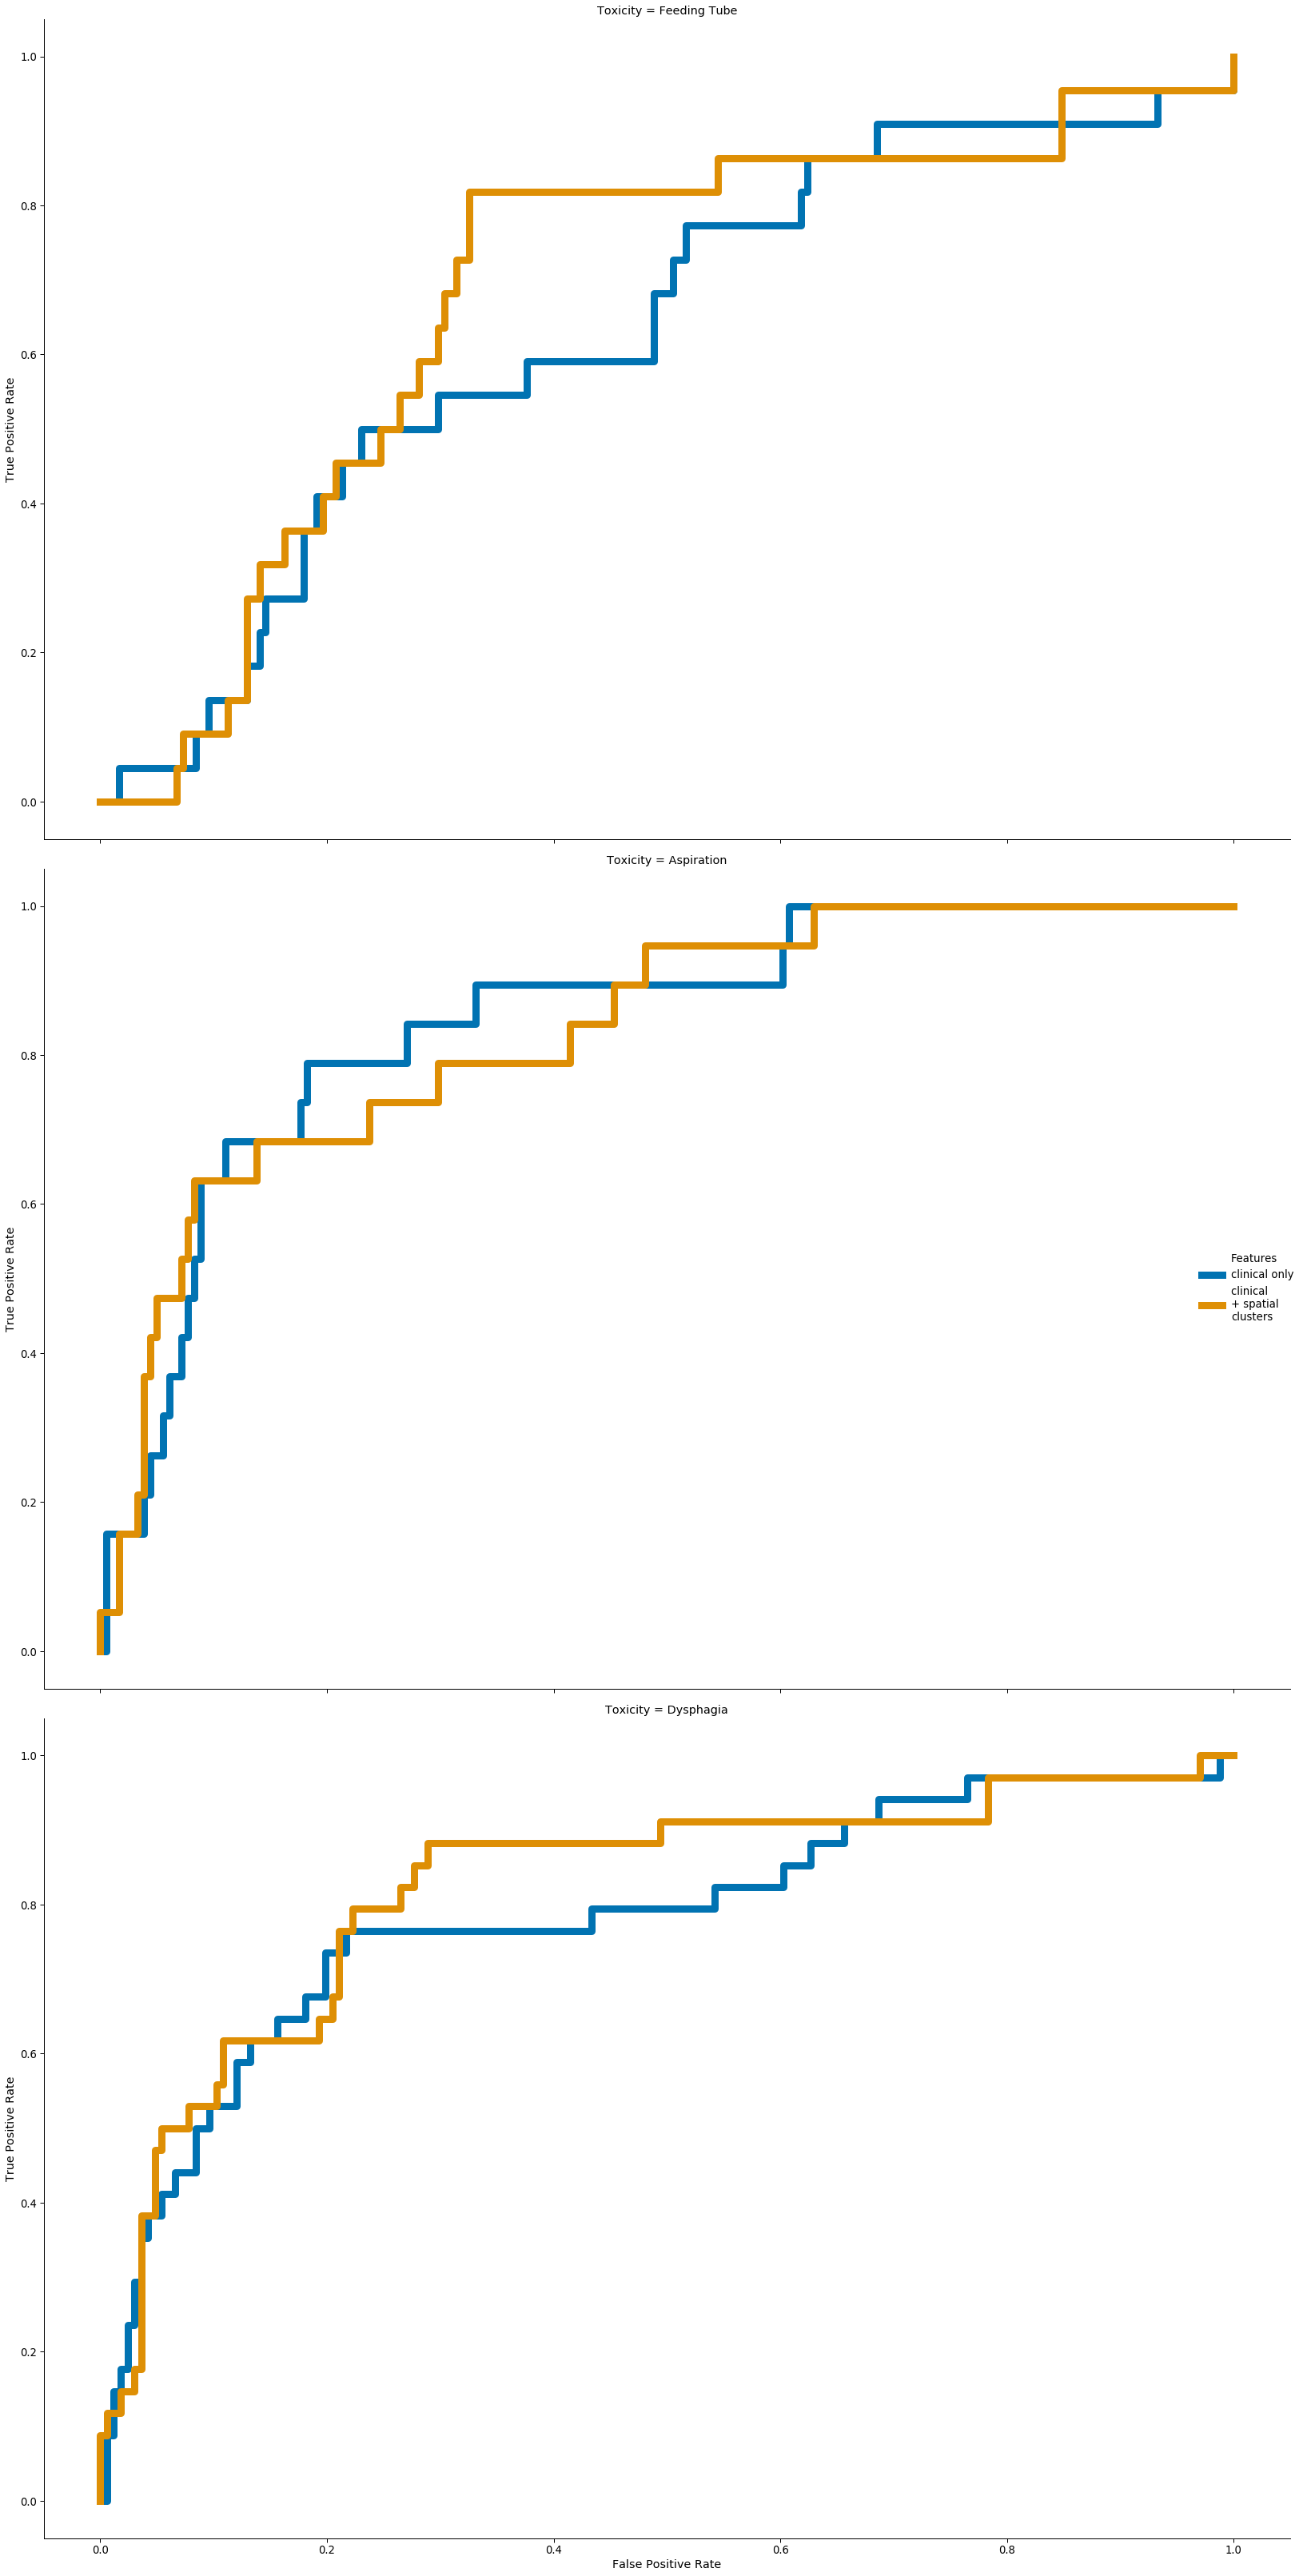

In [18]:
with sns.color_palette(palette, 8):
    #commented part makes them all different plots
#     ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
#                     hue ='Toxicity',
#                     style = 'Features',
#                     data = curves, 
#                     kind='line',
#                     height = fig_height,
#                     aspect = aspect,
#                     estimator = None)
    plt.suptitle('ROC Curves')
    ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
                    hue ='Features',
                    row = 'Toxicity',
                    data = curves, 
                    kind='line',
                    height = fig_height,
                    aspect = aspect,
                     legend = 'brief',
                    estimator = None)
    plt.tight_layout()

In [ ]:
#maybe no use this?
# features_to_drop = []
# temp_scores = []
# spatial = spatial_features.drop(['cluster_labels'], axis = 1)
# best_clusterer = BestClusterer(min_clusters = 2, max_clusters = 5)
# for feature in spatial.columns[::-1]:
#     x = spatial.drop(features_to_drop, axis = 1).values
#     clusters = best_clusterer.fit_predict(x,db.toxicity)
#     temp_scores.append(fisher_exact_test(clusters, db.toxicity))
#     features_to_drop.append(feature)
# plt.plot(np.arange(len(temp_scores)), np.log(1/np.array(temp_scores)[::-1]))

In [21]:
test_range = np.arange(1, 150)
n_subsamples = 500

def get_valid_id_subset(n_to_remove, outcome = 'toxicity', min_value = 2):
    data = db.to_dataframe([outcome])
    dsize = data.shape[0] - n_to_remove
    ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    while data.loc[ids_to_keep].sum().values < min_value:
        ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    return ids_to_keep

def auc_subset_scores(clusterer, n_subsamples = n_subsamples, test_range = test_range):
    auc_subset_scores = np.zeros((n_subsamples, len(test_range)))
    for pos, n_to_remove in enumerate(test_range):
        subsample_count = np.min([n_subsamples, n_to_remove*db.get_num_patients()])
        for n in range(n_subsamples):
            ids_to_keep = get_valid_id_subset( n_to_remove)
#             ids_to_keep = np.random.choice(db.ids, (db.get_num_patients() - n_to_remove,), replace = False) 
            _, _, auc_score = get_subset_roc(ids_to_keep, clusterer = clusterer)
            auc_subset_scores[n, pos] = auc_score
        print(auc_subset_scores[:,pos].mean())
    sensitivity = pd.DataFrame(auc_subset_scores, columns = test_range)
    return sensitivity

def format_data(report,  max_x = None, min_x = 0):
    report_cols = ['number_removed', 'auc']
    n_steps = np.min([report.shape[1], max_x]) - min_x
    report_data = np.zeros((report.shape[0]*n_steps, 2))
    pos = 0
    for x, r in enumerate(report.T.itertuples()):
        if x < min_x:
            continue
        if max_x is not None and x >= max_x:
            break
        n_patients = r[0]
        for t in r[1:]:
            report_data[pos,:] = [n_patients, t]
            pos += 1
    data = pd.DataFrame(report_data, columns = report_cols)
    return data

def plot_report(report_list, names, max_x = None):
    reports = [format_data(report, max_x) for report in report_list]
    final_report = []
    for report, name in zip(reports, names):
        report['group'] = np.full((report.shape[0],), name)
        final_report.append(report)
    data = pd.concat(final_report, ignore_index = True)
    rc = {'figure.figsize':(1,1),
          'lines.linewidth': 10}
    sns.set_context("paper", font_scale = 14, rc=rc)
    sns.lineplot(x='number_removed',y='auc', hue='group',style = 'group', data=data)

In [ ]:
sensitivity_clusters = auc_subset_scores(default_clusterer())
sensitivity_clusters.describe()

0.8216153984923651


In [ ]:
sensitivity_no_clusters = auc_subset_scores(None)
sensitivity_no_clusters.describe()

In [543]:
plot_report([sensitivity_no_clusters, sensitivity_clusters], ['no_clusters', 'clusters'], len(test_range))

0.4

In [250]:
def get_feature_auc(feature_df = None, outcome_name = 'toxicity', patient_ids = db.ids,
                           classifier = None, cluster = False):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    if feature_df is not None:
        features = feature_df.loc[patient_ids]
        if cluster:
            fvalues = features.values
            if fvalues.ndim < 2:
                fvalues = fvalues.reshape(-1,1)
            clusters = FClusterer(4,dist_func = l2).fit_predict(fvalues)
            clusters = pd.get_dummies(clusters)
            clusters.index = features.index
            features = clusters
        elif isinstance(features, pd.Series):
            features = pd.DataFrame(features)
        clinical = clinical.sort_index()
        features = features.sort_index()
        for f in features.columns:
            clinical[f] = features[f].values
    probs = loo_cross_val_proba(classifier, clinical, outcomes)

    auc_score = roc_auc_score(outcomes.values, probs)
    return auc_score

def get_extra_features(dose_organs = ['Mandible', 'Rt_Ant_Digastric_M', 'Lt_Ant_Digastric_M'], 
                       volume_organs = ['Rt_Sternocleidomastoid_M','Lt_Sternocleidomastoid_M', 'Rt_Masseter_M', 'Lt_Masseter_M'], 
                       idx_name = 'Dummy.ID'):
    features = db.to_dataframe(['doses'], organ_list = dose_organs, merge_mirrored_organs = True)
    features = db.to_dataframe(['volumes'], 
                               organ_list = volume_organs, 
                               merge_mirrored_organs = True, 
                               to_merge = features)
    if idx_name is not None:
        features.index = features.index.rename(idx_name)
    return features

def get_features_to_isolate():
    features = get_extra_features()
    features = Metrics.normalize(features)
    features = features.merge(spatial_features.drop('cluster_labels',axis=1), on = ['Dummy.ID'])
    return features

In [206]:
#this gives the auc increases when you don't bootrapped of features auc increase from baseline features vs original clusters reported 
def get_feature_auc_increases():
    features = get_features_to_isolate()
    feature_scores = {}
    baseline = get_feature_auc()
    goodest_auc = get_feature_auc(spatial_features.drop('cluster_labels',axis=1), cluster = True)
    feature_scores['Spatial Clustering'] = goodest_auc - baseline
    for fname in features.columns:
        score = get_feature_auc(features[fname])
        feature_scores[fname] = score - baseline
    return feature_scores

def plot_auc_increases():
    feature_scores = get_feature_auc_increases()
    names, scores = list(zip(*sorted(feature_scores.items(), key = lambda x: x[1])))
    names = ['Spatial Clustering',  
             'Medial Pterygoid Predicted Dose (Mean)', 
             'Mandible True Dose',
            'Extended Oral Cavity Predicted Dose',
            'Sternocleidomastoid Volume (Mean)',
            'Mandible Predicted Dose',
            'Anterior Digastric True Dose (Mean)',
            'Mandible-Tumor Distance',
            'MPC-Tumor Distance',
            'Total GTV']
    names = names[::-1]
    plt.barh(range(len(scores)), scores, align = 'center')
    plt.yticks( range(len(names)), names)
    plt.xlabel('AUC Score Increase')
    plt.show()

In [251]:
from sklearn.utils import resample
def boostrapped_auc_increase(n_samples = 1):
    features = get_features_to_isolate()
    feature_scores =[]
    for n in range(n_samples):
        print(100*n/n_samples, '% done')
        if n_samples > 1:
            ids = resample(db.ids, stratify = db.toxicity)
        else:
            ids = db.ids
        baseline = get_feature_auc(patient_ids = ids)
        for use_clusters in (True, False):
            goodest_auc = get_feature_auc(spatial_features.drop('cluster_labels',axis=1), patient_ids = ids, cluster = use_clusters)
            feature_scores.append(['Spatial Features', goodest_auc, str(use_clusters)])
            for fname in features.columns:
                score = get_feature_auc(features[fname], patient_ids = ids, cluster = use_clusters)
                feature_scores.append([fname, score, str(use_clusters)])
    return pd.DataFrame(feature_scores, columns= ['Feature','AUC','Clustered'])

In [ ]:
fdata = boostrapped_auc_increase(500)

0.0 % done
0.002 % done
0.004 % done
0.006 % done
0.008 % done
0.01 % done
0.012 % done
0.014 % done


In [ ]:
rc = {'figure.figsize':(100,100),
          'lines.linewidth': 1}
sns.set_context("paper", font_scale = 1, rc=rc)
sns.boxplot(y = 'Feature',x = 'AUC', data = fdata, orient='h', hue = "Clustered")